In [31]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [32]:
scene = mi.load_file(r"C:/Users/HTCV_DIRME/Downloads/scene.xml", integrator='prb')

# Render the reference image
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1024, 1024],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 MiB of image data ]
]

In [33]:
#print(params.keys())


In [34]:
params = mi.traverse(scene)
key = 'RightWallBSDF.brdf_0.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()
print("hello")

hello


In [35]:
image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1024, 1024],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 MiB of image data ]
]

In [36]:
opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

In [37]:
def mse(image):
    return dr.mean(dr.sqr(image-image_ref))

iteration_count = 50
print("full")

full


In [39]:
errors = []
for it in range(iteration_count):
    image = mi.render(scene, params, spp=4)
    loss = mse(image)
    dr.backward(loss)
    opt.step()
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)
    params.update(opt)
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration{it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
    print("\n Optimization complete.")

Iteration00: parameter error = 0.526729
 Optimization complete.
Iteration01: parameter error = 0.445916
 Optimization complete.
Iteration02: parameter error = 0.378214
 Optimization complete.
Iteration03: parameter error = 0.320521
 Optimization complete.
Iteration04: parameter error = 0.270316
 Optimization complete.
Iteration05: parameter error = 0.226199
 Optimization complete.
Iteration06: parameter error = 0.187208
 Optimization complete.
Iteration07: parameter error = 0.152626
 Optimization complete.
Iteration08: parameter error = 0.122066
 Optimization complete.
Iteration09: parameter error = 0.095374
 Optimization complete.
Iteration10: parameter error = 0.072425
 Optimization complete.
Iteration11: parameter error = 0.053027
 Optimization complete.
Iteration12: parameter error = 0.036974
 Optimization complete.
Iteration13: parameter error = 0.024122
 Optimization complete.
Iteration14: parameter error = 0.014369
 Optimization complete.
Iteration15: parameter error = 0.007582


In [40]:
image_final =mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1024, 1024],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 MiB of image data ]
]

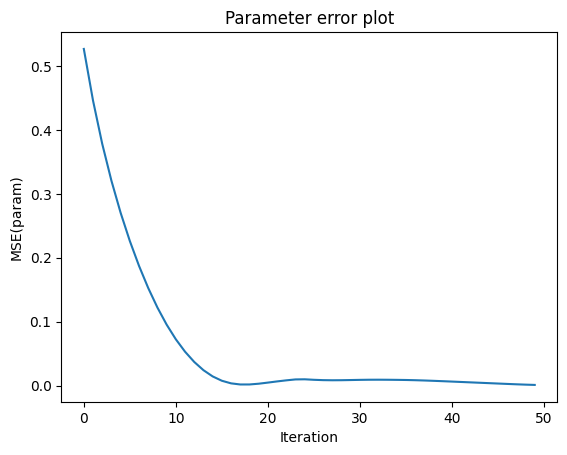

In [41]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()